<a href="https://colab.research.google.com/github/AsadiAhmad/TF-IDF-Model/blob/main/Code/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [34]:
import requests

import numpy as np
import polars as pl

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

# Step 2: Download Documents and Queries

In [2]:
def download_text(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch {url}. Status code: {response.status_code}")
        return None

In [3]:
urls = {
    "Documents": "https://raw.githubusercontent.com/AsadiAhmad/TF-IDF-Model/main/Dataset/Documents.txt",
    "Queries": "https://raw.githubusercontent.com/AsadiAhmad/TF-IDF-Model/main/Dataset/Queries.txt",
    "Result": "https://raw.githubusercontent.com/AsadiAhmad/TF-IDF-Model/main/Dataset/Result.txt"
}

In [4]:
data = {}
for key, url in urls.items():
    data[key] = download_text(url)

print("Datasets downloaded successfully!")

Datasets downloaded successfully!


# Step 3: Convert Dataset into Polars Data frame

## Convert into polars

In [5]:
documents_text = data["Documents"]
queries_text = data["Queries"]
result_text = data["Result"]

In [6]:
documents_splited = documents_text.split('********************************************')

for index, doc in enumerate(documents_splited):
    documents_splited[index] = doc.strip()

documents = pl.DataFrame({
    "index": range(1, len(documents_splited) + 1),
    "text": documents_splited
})

documents = documents.with_columns(
    pl.col("text")
    .str.split("\n")
    .list.slice(1)
    .list.join(" ")
    .str.replace_all(r'\s+', ' ')
    .str.strip_chars()
)

In [7]:
queries_splited = queries_text.split('#')

for index, doc in enumerate(queries_splited):
    queries_splited[index] = doc.strip()

queries = pl.DataFrame({
    "index": range(1, len(queries_splited) + 1),
    "text": queries_splited
})

queries = queries.with_columns(
    pl.col("text")
    .str.split("\n")
    .list.slice(1)
    .list.join(" ")
    .str.replace_all(r'\s+', ' ')
    .str.strip_chars()
)

In [8]:
reference_lines = []
for line in result_text.split('\n'):
    line = line.strip()
    if line.endswith('-1'):
        refs = line[:-2].strip().split()
        reference_lines.append([int(ref) for ref in refs])

result = pl.DataFrame({
    "index": range(1, len(reference_lines) + 1),
    "references": reference_lines
})

## Set Config for polar showing

In [9]:
pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(70)
pl.Config.set_fmt_table_cell_list_len(10)

polars.config.Config

## Showing all frames

In [13]:
print(documents.row(0, named=True))

{'index': 1, 'text': 'THE INDIAN COUNCIL OF LIBRARY AND INFORMATION SERVICES RESEARCH AND TRAINING: A PROPOSAL FOR CONSIDERATION. CRITICALLY EXAMINES THE INDIAN LIBRARY SCENE. THE MANAGEMENT, OPERATION, AND SERVICES OF MOST LIBRARIES IS INEFFICIENT AND INEFFECTIVE, RESULTING IN GRAVE MISALLOCATION AND UNDERUTILISATION OF LIBRARY RESOURCES. LITTLE MAJOR RESEARCH HAS BEEN CARRIED OUT. UNIVERSITY LIBRARIANSHIP COURSES ARE NOT MUCH HELP FOR MANAGING AND OPERATING LIBRARIES EFFICIENTLY. THE MAJOR NATIONAL INSTITUTIONS HAVE SERIOUS LIMITATIONS. TO IMPROVE THE SITUATION, PROPOSES THE ESTABLISHMENT OF AN INDIAN COUNCIL OF LIBRARY AND INFORMATION SERVICES RESEARCH AND TRAINING. THE COUNCIL WOULD BE SET UP BY THE GOVERNMENT AND HAVE WELL-DEFINED ROLES AND FUNCTIONS COVERING ALL ASPECTS OF INDIAN LIBRARIANSHIP.'}


In [10]:
documents.head(10)

index,text
i64,str
1,"""THE INDIAN COUNCIL OF LIBRARY AND INFORMATION SERVICES RESEARCH AND TR…"
2,"""THE LINGERING FRAGRANCE: PROCEEDINGS OF THE XXIV ALL INDIA LIBRARY CON…"
3,"""XXV ALL INDIA LIBRARY CONFERENCE TRIVANDRUM 14-18 MAY 1979. PAPERS AND…"
4,"""MALAWI LIBRARY ASSOCIATION SECOND ANNUAL GENERAL MEETING, CHANCELLOR C…"
5,"""A PERSONAL VIEW OF THE ZAMBIA LIBRARY SERVICE. PERSONAL VIEW OF THE SE…"
6,"""CLA 80: TURNING ON THE POWER. REPORT OF PROCEEDINGS OF THE 35TH ANNUAL…"
7,"""UNCERTAIN BEGINNINGS. REPORT OF THE AMERICAN LIBRARY ASSOCIATION MIDWI…"
8,"""MIDWINTER IN REAGAN'S WASHINGTON: AN ALA CONFERENCE REPORT. REPORT OF …"
9,"""THE WHITE HOUSE CONFERENCE ON LIBRARY AND INFORMATION SERVICES, 1979. …"


In [11]:
queries.head(10)

index,text
i64,str
1,"""I AM INTERESTED IN THE IDENTIFICATION AND EVALUATION OF NOVEL COMPUTER…"
2,"""I WOULD BE INTERESTED TO RECEIVE INFORMATION ON NON-USERS OF LIBRARIES…"
3,"""I AM INTERESTED IN COMPUTER DOCUMENTATION SYSTEMS FOR CHEMICAL PATENTS…"
4,"""I WOULD BE PLEASED TO RECEIVE ANY INFORMATION ON THE USE OF JOURNALS I…"
5,"""MY DISSERTATION IS AN OVERVIEW OF NEWS DATABASES, LOOKING AT THE AVAIL…"
6,"""MY DISSERTATION IS ON LIBRARY OUTREACH FOR THE CHINESE COMMUNITY IN SH…"
7,"""I WOULD BE PLEASED TO RECEIVE PAPERS ON THE SECURITY OF INFORMATION IN…"
8,"""I AM INTERESTED IN THE PROFESSIONAL EDUCATION OF LIBRARIANS, IN PARTIC…"
9,"""I AM INTERESTED IN THE EXTENT TO WHICH LIBRARIES ARE CHARGING FOR SERV…"


In [12]:
result.head(10)

index,references
i64,list[i64]
1,"[3392, 3396]"
2,"[2623, 4291]"
3,"[1407, 1431, 3794, 3795, 3796]"
4,"[604, 3527, 4644, 5087, 5112, 5113, 5295]"
5,[3401]
6,"[5626, 5627, 5628, 5629, 5631]"
7,"[277, 278, 279, 1277, 1278, 1769, 2279, 3265, 3267, … 5778]"
8,"[4485, 4486, 4499, 4717, 5011, 5170, 5533, 5534, 5723, 5816]"
9,"[178, 680, 681, 1412, 3178, 3689, 3922, 4374, 4692, … 5859]"


# Step 4: Preprocess

## Clear garbage charachters and digits

In [18]:
def clean_text(df):
    df = df.with_columns(
        pl.col("text")
        .str.replace_all(r"[.,(){}\[\]*&^%$#@!?_\-+=/\\`~'\";:]", " ") # Remove special characters
        .str.replace_all(r"\d", " ")                                   # Remove digits
        .str.replace_all(r"\s+", " ")                                  # Replace multiple whitespace with single space
        .str.strip_chars()                                             # Remove leading/trailing whitespace
    )
    return df

In [19]:
documents_clean = clean_text(documents)
queries_clean = clean_text(queries)

In [20]:
documents_clean.head(10)

index,text
i64,str
1,"""THE INDIAN COUNCIL OF LIBRARY AND INFORMATION SERVICES RESEARCH AND TR…"
2,"""THE LINGERING FRAGRANCE PROCEEDINGS OF THE XXIV ALL INDIA LIBRARY CONF…"
3,"""XXV ALL INDIA LIBRARY CONFERENCE TRIVANDRUM MAY PAPERS AND PROCEEDINGS…"
4,"""MALAWI LIBRARY ASSOCIATION SECOND ANNUAL GENERAL MEETING CHANCELLOR CO…"
5,"""A PERSONAL VIEW OF THE ZAMBIA LIBRARY SERVICE PERSONAL VIEW OF THE SER…"
6,"""CLA TURNING ON THE POWER REPORT OF PROCEEDINGS OF THE TH ANNUAL CANADI…"
7,"""UNCERTAIN BEGINNINGS REPORT OF THE AMERICAN LIBRARY ASSOCIATION MIDWIN…"
8,"""MIDWINTER IN REAGAN S WASHINGTON AN ALA CONFERENCE REPORT REPORT OF TH…"
9,"""THE WHITE HOUSE CONFERENCE ON LIBRARY AND INFORMATION SERVICES SUMMARY…"


In [21]:
queries_clean.head(10)

index,text
i64,str
1,"""I AM INTERESTED IN THE IDENTIFICATION AND EVALUATION OF NOVEL COMPUTER…"
2,"""I WOULD BE INTERESTED TO RECEIVE INFORMATION ON NON USERS OF LIBRARIES…"
3,"""I AM INTERESTED IN COMPUTER DOCUMENTATION SYSTEMS FOR CHEMICAL PATENTS…"
4,"""I WOULD BE PLEASED TO RECEIVE ANY INFORMATION ON THE USE OF JOURNALS I…"
5,"""MY DISSERTATION IS AN OVERVIEW OF NEWS DATABASES LOOKING AT THE AVAILA…"
6,"""MY DISSERTATION IS ON LIBRARY OUTREACH FOR THE CHINESE COMMUNITY IN SH…"
7,"""I WOULD BE PLEASED TO RECEIVE PAPERS ON THE SECURITY OF INFORMATION IN…"
8,"""I AM INTERESTED IN THE PROFESSIONAL EDUCATION OF LIBRARIANS IN PARTICU…"
9,"""I AM INTERESTED IN THE EXTENT TO WHICH LIBRARIES ARE CHARGING FOR SERV…"


## Lower all alphabet charachters

In [22]:
def lower_text(df):
    df = df.with_columns(
        pl.col("text")
        .str.to_lowercase()
    )
    return df

In [23]:
documents_lower = lower_text(documents_clean)
queries_lower = lower_text(queries_clean)

In [24]:
documents_lower.head(10)

index,text
i64,str
1,"""the indian council of library and information services research and tr…"
2,"""the lingering fragrance proceedings of the xxiv all india library conf…"
3,"""xxv all india library conference trivandrum may papers and proceedings…"
4,"""malawi library association second annual general meeting chancellor co…"
5,"""a personal view of the zambia library service personal view of the ser…"
6,"""cla turning on the power report of proceedings of the th annual canadi…"
7,"""uncertain beginnings report of the american library association midwin…"
8,"""midwinter in reagan s washington an ala conference report report of th…"
9,"""the white house conference on library and information services summary…"


In [25]:
queries_lower.head(10)

index,text
i64,str
1,"""i am interested in the identification and evaluation of novel computer…"
2,"""i would be interested to receive information on non users of libraries…"
3,"""i am interested in computer documentation systems for chemical patents…"
4,"""i would be pleased to receive any information on the use of journals i…"
5,"""my dissertation is an overview of news databases looking at the availa…"
6,"""my dissertation is on library outreach for the chinese community in sh…"
7,"""i would be pleased to receive papers on the security of information in…"
8,"""i am interested in the professional education of librarians in particu…"
9,"""i am interested in the extent to which libraries are charging for serv…"


## Tokenization

In [26]:
def tokenize_text(df, text_col="text"):
    return df.with_columns(pl.col(text_col).str.split(" ").alias("token"))

In [27]:
documents_tokenized = tokenize_text(documents_lower)
queries_tokenized = tokenize_text(queries_lower)

In [28]:
documents_tokenized.head(10)

index,text,token
i64,str,list[str]
1,"""the indian council of library and information services research and tr…","[""the"", ""indian"", ""council"", ""of"", ""library"", ""and"", ""information"", ""services"", ""research"", … ""librarianship""]"
2,"""the lingering fragrance proceedings of the xxiv all india library conf…","[""the"", ""lingering"", ""fragrance"", ""proceedings"", ""of"", ""the"", ""xxiv"", ""all"", ""india"", … ""feb""]"
3,"""xxv all india library conference trivandrum may papers and proceedings…","[""xxv"", ""all"", ""india"", ""library"", ""conference"", ""trivandrum"", ""may"", ""papers"", ""and"", … ""kerala""]"
4,"""malawi library association second annual general meeting chancellor co…","[""malawi"", ""library"", ""association"", ""second"", ""annual"", ""general"", ""meeting"", ""chancellor"", ""college"", … ""organisations""]"
5,"""a personal view of the zambia library service personal view of the ser…","[""a"", ""personal"", ""view"", ""of"", ""the"", ""zambia"", ""library"", ""service"", ""personal"", … ""activities""]"
6,"""cla turning on the power report of proceedings of the th annual canadi…","[""cla"", ""turning"", ""on"", ""the"", ""power"", ""report"", ""of"", ""proceedings"", ""of"", … ""cla""]"
7,"""uncertain beginnings report of the american library association midwin…","[""uncertain"", ""beginnings"", ""report"", ""of"", ""the"", ""american"", ""library"", ""association"", ""midwinter"", … ""organisations""]"
8,"""midwinter in reagan s washington an ala conference report report of th…","[""midwinter"", ""in"", ""reagan"", ""s"", ""washington"", ""an"", ""ala"", ""conference"", ""report"", … ""center""]"
9,"""the white house conference on library and information services summary…","[""the"", ""white"", ""house"", ""conference"", ""on"", ""library"", ""and"", ""information"", ""services"", … ""ntis""]"


In [29]:
queries_tokenized.head(10)

index,text,token
i64,str,list[str]
1,"""i am interested in the identification and evaluation of novel computer…","[""i"", ""am"", ""interested"", ""in"", ""the"", ""identification"", ""and"", ""evaluation"", ""of"", … ""memory""]"
2,"""i would be interested to receive information on non users of libraries…","[""i"", ""would"", ""be"", ""interested"", ""to"", ""receive"", ""information"", ""on"", ""non"", … ""studies""]"
3,"""i am interested in computer documentation systems for chemical patents…","[""i"", ""am"", ""interested"", ""in"", ""computer"", ""documentation"", ""systems"", ""for"", ""chemical"", … ""patents""]"
4,"""i would be pleased to receive any information on the use of journals i…","[""i"", ""would"", ""be"", ""pleased"", ""to"", ""receive"", ""any"", ""information"", ""on"", … ""libraries""]"
5,"""my dissertation is an overview of news databases looking at the availa…","[""my"", ""dissertation"", ""is"", ""an"", ""overview"", ""of"", ""news"", ""databases"", ""looking"", … ""reporter""]"
6,"""my dissertation is on library outreach for the chinese community in sh…","[""my"", ""dissertation"", ""is"", ""on"", ""library"", ""outreach"", ""for"", ""the"", ""chinese"", … ""society""]"
7,"""i would be pleased to receive papers on the security of information in…","[""i"", ""would"", ""be"", ""pleased"", ""to"", ""receive"", ""papers"", ""on"", ""the"", … ""access""]"
8,"""i am interested in the professional education of librarians in particu…","[""i"", ""am"", ""interested"", ""in"", ""the"", ""professional"", ""education"", ""of"", ""librarians"", … ""education""]"
9,"""i am interested in the extent to which libraries are charging for serv…","[""i"", ""am"", ""interested"", ""in"", ""the"", ""extent"", ""to"", ""which"", ""libraries"", … ""services""]"


## Word Counting

In [43]:
def count_words(df, token_col="token"):
    all_tokens = [word for tokens in df[token_col].to_list() for word in tokens if word != ""]
    word_counts = Counter(all_tokens)
    unique_words = set(word_counts.keys())
    return pl.DataFrame({"word": list(word_counts.keys()), "count": list(word_counts.values())}).sort("count", descending=True), len(unique_words)

In [44]:
documents_counted, documents_uniqe = count_words(documents_tokenized)
queries_counted, queries_uniqe = count_words(queries_tokenized)

In [45]:
documents_uniqe

17654

In [46]:
queries_uniqe

585

In [32]:
documents_counted.head(10)

word,count
str,i64
"""the""",41413
"""of""",30371
"""and""",24998
"""in""",15028
"""to""",12146
"""a""",11591
"""library""",8693
"""for""",7981
"""information""",5670


In [33]:
queries_counted.head(10)

word,count
str,i64
"""in""",78
"""of""",78
"""the""",72
"""and""",62
"""i""",55
"""information""",53
"""am""",31
"""interested""",31
"""on""",30


## Show Zipf Law

In [35]:
def plot_zipf_distribution(word_freq_df):
    ranks = np.arange(1, len(word_freq_df) + 1)
    frequencies = word_freq_df["count"].to_numpy()

    plt.figure(figsize=(6, 3))
    plt.loglog(ranks, frequencies, marker="o", linestyle="none", label="Observed Data")
    plt.xlabel("Rank (log)")
    plt.ylabel("Frequency (log)")
    plt.title("Zipf's Law Distribution of Word Frequencies")
    plt.legend()
    plt.grid(True)
    plt.show()

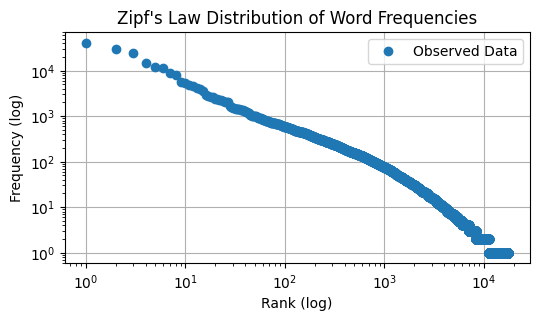

In [36]:
plot_zipf_distribution(documents_counted)

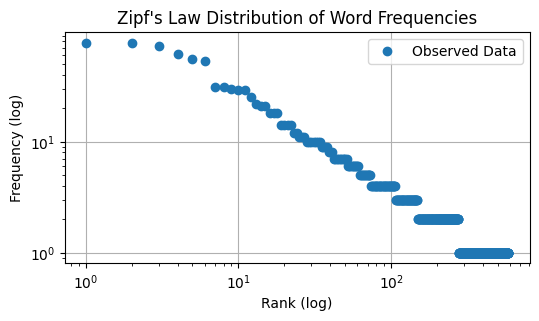

In [47]:
plot_zipf_distribution(queries_counted)

## Calculate stop and steⅿⅿing words

In [48]:
def filter_words_by_frequency(word_freq_df, min_count=25, max_count_ratio=0.01):
    total_words = word_freq_df["count"].sum()
    max_count = total_words * max_count_ratio

    filtered_df = word_freq_df.filter(
        (pl.col("count") >= min_count) &
        (pl.col("count") <= max_count)
    )

    removed_words = set(word_freq_df["word"].to_list()) - set(filtered_df["word"].to_list())
    removed_words.add("")
    return filtered_df, removed_words

In [49]:
_, removal_words = filter_words_by_frequency(documents_counted)

documents_removed = documents_counted.filter(
    ~pl.col("word").is_in(list(removal_words))
)

queries_removed = queries_counted.filter(
    ~pl.col("word").is_in(list(removal_words))
)

In [50]:
documents_removed.head(10)

word,count
str,i64
"""on""",5386
"""is""",4958
"""libraries""",4632
"""are""",4145
"""by""",4038
"""with""",3606
"""as""",2865
"""s""",2812
"""an""",2633


In [51]:
queries_removed.head(10)

word,count
str,i64
"""i""",55
"""interested""",31
"""on""",30
"""libraries""",29
"""be""",25
"""would""",21
"""systems""",21
"""or""",18
"""any""",18


In [52]:
removal_words

{'',
 'crosspoint',
 'regionally',
 'bs',
 'sni',
 'ceefax',
 'monacenses',
 'grigg',
 'favourites',
 'belvoir',
 'hedwig',
 'kommune',
 'threads',
 'executed',
 'cohesion',
 'plant',
 'regretfully',
 'iniss',
 'sutton',
 'chronicle',
 'wandsworth',
 'mime',
 'interprocess',
 'exhausted',
 'modellification',
 'commentary',
 'inept',
 'marjorie',
 'counted',
 'republication',
 'justly',
 'imagined',
 'manuals',
 'casin',
 'teleprinter',
 'supreme',
 'indications',
 'positively',
 'lesson',
 'curve',
 'william',
 'red',
 'treatise',
 'richest',
 'dismissals',
 'vineyards',
 'profess',
 'sdk',
 'blld',
 'lippmann',
 'cr',
 'hygiene',
 'isn',
 'nicolay',
 'mountainous',
 'inspection',
 'specified',
 'wish',
 'indies',
 'yankee',
 'banbury',
 'eutin',
 'impediment',
 'phantom',
 'clergy',
 'biased',
 'typing',
 'drcs',
 'undertook',
 'convenient',
 'tanganyika',
 'breivik',
 'heslegrave',
 'entailed',
 'dwellers',
 'chadwyck',
 'sh',
 'happiness',
 'superex',
 'disturbed',
 'saxony',
 'sign

## Remove stop and steⅿⅿing words

In [53]:
def remove_abandon_words(df, remove_word_list, token_col="token"):
    return df.with_columns(
        pl.col(token_col).list.eval(
            pl.element().filter(pl.element().is_in(remove_word_list).not_())
        ).alias(token_col)
    )

In [54]:
documents_refined = remove_abandon_words(documents_tokenized, removal_words)
queries_refined = remove_abandon_words(queries_tokenized, removal_words)

In [55]:
documents_refined.head(10)

index,text,token
i64,str,list[str]
1,"""the indian council of library and information services research and tr…","[""indian"", ""council"", ""services"", ""research"", ""training"", ""proposal"", ""consideration"", ""examines"", ""indian"", … ""librarianship""]"
2,"""the lingering fragrance proceedings of the xxiv all india library conf…","[""proceedings"", ""all"", ""india"", ""conference"", ""papers"", ""proceedings"", ""from"", ""conference"", ""with"", … ""feb""]"
3,"""xxv all india library conference trivandrum may papers and proceedings…","[""all"", ""india"", ""conference"", ""may"", ""papers"", ""proceedings"", ""conference"", ""papers"", ""relate"", … ""movement""]"
4,"""malawi library association second annual general meeting chancellor co…","[""association"", ""annual"", ""general"", ""meeting"", ""college"", ""summary"", ""proceedings"", ""lists"", ""those"", … ""organisations""]"
5,"""a personal view of the zambia library service personal view of the ser…","[""personal"", ""view"", ""service"", ""personal"", ""view"", ""service"", ""based"", ""on"", ""observations"", … ""activities""]"
6,"""cla turning on the power report of proceedings of the th annual canadi…","[""on"", ""power"", ""report"", ""proceedings"", ""th"", ""annual"", ""canadian"", ""association"", ""conference"", … ""year""]"
7,"""uncertain beginnings report of the american library association midwin…","[""report"", ""american"", ""association"", ""meeting"", ""washington"", ""jan"", ""feb"", ""expressed"", ""about"", … ""organisations""]"
8,"""midwinter in reagan s washington an ala conference report report of th…","[""s"", ""washington"", ""an"", ""ala"", ""conference"", ""report"", ""report"", ""american"", ""association"", … ""center""]"
9,"""the white house conference on library and information services summary…","[""white"", ""house"", ""conference"", ""on"", ""services"", ""summary"", ""an"", ""abstract"", ""this"", … ""ntis""]"


In [56]:
queries_refined.head(10)

index,text,token
i64,str,list[str]
1,"""i am interested in the identification and evaluation of novel computer…","[""i"", ""interested"", ""identification"", ""evaluation"", ""computer"", ""increased"", ""parallelism"", ""both"", ""simd"", … ""memory""]"
2,"""i would be interested to receive information on non users of libraries…","[""i"", ""would"", ""be"", ""interested"", ""receive"", ""on"", ""non"", ""users"", ""libraries"", … ""studies""]"
3,"""i am interested in computer documentation systems for chemical patents…","[""i"", ""interested"", ""computer"", ""documentation"", ""systems"", ""chemical"", ""patents"", ""i"", ""would"", … ""patents""]"
4,"""i would be pleased to receive any information on the use of journals i…","[""i"", ""would"", ""be"", ""receive"", ""any"", ""on"", ""use"", ""journals"", ""libraries"", … ""libraries""]"
5,"""my dissertation is an overview of news databases looking at the availa…","[""dissertation"", ""is"", ""an"", ""overview"", ""news"", ""at"", ""availability"", ""content"", ""scope"", … ""world""]"
6,"""my dissertation is on library outreach for the chinese community in sh…","[""dissertation"", ""is"", ""on"", ""chinese"", ""community"", ""but"", ""i"", ""would"", ""be"", … ""society""]"
7,"""i would be pleased to receive papers on the security of information in…","[""i"", ""would"", ""be"", ""receive"", ""papers"", ""on"", ""security"", ""databanks"", ""or"", … ""access""]"
8,"""i am interested in the professional education of librarians in particu…","[""i"", ""interested"", ""professional"", ""education"", ""librarians"", ""particular"", ""any"", ""service"", ""training"", … ""education""]"
9,"""i am interested in the extent to which libraries are charging for serv…","[""i"", ""interested"", ""extent"", ""which"", ""libraries"", ""are"", ""services"", ""this"", ""public"", … ""services""]"


# Step 5: